## Projeto DSA: Prevendo o Nível de Satisfação dos Clientes do Santander
### Projeto: criar um modelo de classificação para prever satisfação do cliente com base em centenas de recursos anônimos.

Dados disponíveis em: https://www.kaggle.com/competitions/santander-customer-satisfaction/data

Importando as bibliotecas necessárias:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

from time import time
start = time()

A fonte de dados possui 3 arquivos:
- train: dataset completo com variáveis preditoras e variável alvo;
- test: dataset com todas variáveis preditoras e registros diferentes de train;
- sample_submission: dataset com a variável alvo e mesmos registros de test.

Carregando os arquivos e realizando uma primeira visualização dos dados em "train":

In [2]:
df_train = pd.read_csv("./santander-customer-satisfaction/train.csv")
df_test = pd.read_csv("./santander-customer-satisfaction/test.csv")
df_target = pd.read_csv("./santander-customer-satisfaction/sample_submission.csv")

df_train.shape

(76020, 371)

In [3]:
df_train.sample(10)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
7521,15072,2,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,131419.590000,0
74665,149105,2,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84247.680000,0
63361,126509,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
6616,13294,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155198.640000,0
32562,65093,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37767.870000,1
75302,150382,2,23,0.0,20.7,20.7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67023.270000,0
28946,57905,2,25,0.0,0.0,66.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,244620.090000,0
8589,17298,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138736.950000,0
28086,56200,2,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33256.050000,1
22110,44280,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75704.880000,0


In [4]:
df_train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


Soma de valores NaN:

In [5]:
print("NA:", df_train.isna().sum(axis=0).sum())
print("Null:", df_train.isnull().sum(axis=0).sum())

NA: 0
Null: 0


Avaliação da variável alvo:

In [6]:
df_train['TARGET'].value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

Avaliando os outliers nas colunas com uma função que, a partir de um zscore definido, retorna o número de outliers de cada variável:

In [7]:
def returnOutliers(df, zscore):
    col_list = df.columns.values
    df2 = pd.DataFrame({"col_name": [], "count_outlier": []})
    
    for n in range(len(col_list)):
        df3 = {"col_name": col_list[n], "count_outlier": 
               (abs(stats.zscore(df[col_list[n]])) > zscore).astype(int).sum()}
        df2 = df2.append(df3, ignore_index=True)
        
    return(df2)

In [8]:
outliers = returnOutliers(df = df_train, zscore = 3).sort_values(by="count_outlier", ascending=False)
outliers[outliers.count_outlier > 0].describe()

,count_outlier
count,328.000000
mean,818.948171
std,1278.894350
min,1.000000
25%,20.000000
50%,205.000000
75%,1295.750000
max,7364.000000


In [9]:
outliers.head(10)

,col_name,count_outlier
257,ind_var9_cte_ult1,7364.0
256,ind_var10cte_ult1,7006.0
258,ind_var9_ult1,6531.0
255,ind_var10_ult1,6148.0
74,ind_var37_cte,5496.0
96,num_var12_0,5133.0
30,ind_var12_0,5133.0
259,ind_var43_emit_ult1,5062.0
75,ind_var37_0,4961.0
76,ind_var37,4961.0


O dataframe possui outliers em quase todas variáveis, porém como as variáveis são anônimas, nada será feito em relação aos outliers.<br>
A variável alvo no dataset de treino está muito desbalanceada e por isso será ajustada com aplicação de PCA e oversampling.

Preparação dos dados e amostragem de 5000 registros para acelerar o treinamento na escolha de hiperparâmetros:

In [10]:
idx = np.random.randint(1, len(df_train), size = 5000)

x_train = df_train.drop(columns = ["ID", "TARGET"])
y_train = df_train["TARGET"]

x_test = df_test.drop(columns = "ID")
y_test = pd.merge(df_test, df_target, on = "ID", how = "inner")["TARGET"]

x_train_idx = df_train.drop(columns = ["ID", "TARGET"]).iloc[idx]
y_train_idx = df_train["TARGET"].iloc[idx]

x_train: **fit + transform** para calcular parâmetros internos e aplicá-los.

x_test: **transform** para aplicar os mesmos parâmetros calculados para o x_train.

Aplicando padronização às variáveis preditoras:

In [11]:
sc = StandardScaler()

x_train_idx = sc.fit_transform(x_train_idx)

Aplicando o PCA para vários valores para avaliar a variância explicada:

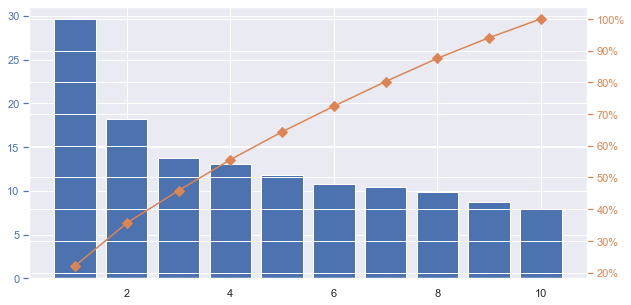

In [12]:
sns.set(rc={"figure.figsize":(10, 5)})

pca = PCA(n_components=10)
x_train_pca = x_train_idx

# Fit e transform:
pca.fit_transform(x_train_pca)

# Valores acumulados:
cumulative_sum = [pca.explained_variance_[n]/pca.explained_variance_.sum() 
                  for n in range(len(pca.explained_variance_))]

df_plot = ((pd.DataFrame(cumulative_sum, columns = ['Variância acumulada (%)']).cumsum())  * 100).round(2)
df_plot['Variância'] = pd.DataFrame(pca.explained_variance_).round(2)

fig, ax = plt.subplots()
ax.bar(df_plot.index + 1, df_plot['Variância'], color='C0')
ax2 = ax.twinx()
ax2.plot(df_plot.index + 1, df_plot['Variância acumulada (%)'], color='C1', marker='D', ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')
plt.show()

O número de componentes escolhidos será 7, pois explica boa parte da variância dos dados e um número maior poderia causar overfitting.

In [13]:
pca = PCA(n_components = 7)

x_train_idx = pd.DataFrame(pca.fit_transform(x_train_idx))

A classe 1 possui poucos registros em relação à classe 0.<br>
Aplicando oversampling para balancear as classes:

In [14]:
ada = ADASYN()
x_resampled, y_resampled = ada.fit_resample(x_train_idx, y_train_idx)

pd.DataFrame(y_resampled).value_counts()

TARGET
0         4757
1         4710
dtype: int64

Aplicação de Grid Search a modelos Random Forest com os dois conjuntos de dados de treino:

In [15]:
rf_model = RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'log2'],
    'max_depth': [2, 3, 5],
    'criterion':['gini', 'entropy']
}

rfc = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv= 5)
rfc.fit(x_train_idx, y_train_idx)

print(rfc.best_params_)

{'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 100}


Criação dos modelos com os parâmetros definidos como melhores e utilizando todo o dataset de treino:

In [16]:
# Padronização:
sc = StandardScaler()

x_train = pd.DataFrame(sc.fit_transform(x_train))
x_test = pd.DataFrame(sc.transform(x_test))

# Escolha dos componentes:
x_train = pd.DataFrame(pca.fit_transform(x_train))
x_test = pd.DataFrame(pca.transform(x_test))

In [17]:
rf_model = RandomForestClassifier(random_state = 0, 
                                     max_features = 'auto', 
                                     n_estimators = 100, 
                                     max_depth = 2, 
                                     criterion = 'gini')

rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=2, max_features='auto', random_state=0)

Predição dos dados de teste e avaliação da acurácia:

In [18]:
y_pred_train = rf_model.predict(x_train)
y_pred = rf_model.predict(x_test)

conf_mtx_train = confusion_matrix(y_train, y_pred_train)
conf_mtx = confusion_matrix(y_test, y_pred)

print(conf_mtx, "\n"*2, "Acurácia em treino:", round(accuracy_score(y_train, y_pred_train), 3), "\n"*2)
print(conf_mtx, "\n"*2, "Acurácia em teste:", round(accuracy_score(y_test, y_pred), 3))

[[75818]] 

 Acurácia em treino: 0.96 


[[75818]] 

 Acurácia em teste: 1.0


In [19]:
print("Tempo total de execução:", round(time()-start, 2), "segundos")

Tempo total: 171.21 segundos
